## 【Quantitative Analysis】TQuant Lab KD Indicator Strategy: Exploring Stock Price Reversal Timing?
Source: [KD Indicator](https://www.tejwin.com/en/insight/kd-indicator/)

### A. Preface

The KD Indicator, also known as the Stochastic Oscillator, is one of the common indicators in technical analysis, primarily used to determine the short-term strength of stock prices and potential reversal timing. The value of the KD indicator ranges from 0 to 100, with 50 generally serving as the dividing line. When the indicator is above 50, it indicates that the stock price is in a bullish phase; conversely, when the indicator is below 50, it is considered to be in a bearish phase. Additionally, when the KD indicator is below 20, stocks often show signs of being oversold, indicating a potential upward reversal at any time; on the other hand, when the KD indicator is above 80, stocks often exhibit signs of being overbought, suggesting a potential downward reversal at any time. Therefore, many people use this as the basis for constructing trading signals for buying and selling stocks.  

In this implementation, we employ the KD indicator to determine stock price reversal timing and utilizes the following entry and exit rules to establish a trading strategy and conduct backtesting:  

- When K ≤ 20: Buy, as it represents a weaker stock price and an oversold market condition.
- When K ≥ 80: Sell, indicating an overheated market, thus opting for profit-taking.

### B. Coding Environment and Module Requirements

In [1]:
import pandas as pd
import numpy as np
import os

tej_key = 'your key'
api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_KEY'] = tej_key 
os.environ['TEJAPI_BASE'] = api_base

### C. Selecting Stock Pool and Data Import

1. Using `get_universe` to select stocks from the Taiwan 50 Index from 2012-01-01 to 2019-12-31.
2. Setting the backtesting period from 2020-01-01 to 2024-04-10, and importing price and volume data using `!zipline ingest -b tquant`.

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

# get the stock from Taiwan 50 index
StockList = get_universe('2012-01-01', '2019-12-31', idx_id = 'IX0002')
StockList.append('IR0001')

Currently used TEJ API key call quota 97/100000 (0.1%)
Currently used TEJ API key data quota 2323780/10000000 (23.24%)


In [3]:
# set backtest period
start = '2020-01-01'
end = '2024-04-10'

os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start + ' ' + end

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 104/100000 (0.1%)
Currently used TEJ API key data quota 2461908/10000000 (24.62%)


[2024-04-16 06:05:34.427003] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-04-16 06:05:44.368046] INFO: zipline.data.bundles.core: Ingest tquant successfully.


### D. Construct the KD Indicator Strategy

#### D.1: Create the `pipeline` Function

In [5]:
from zipline.pipeline import Pipeline
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.factors import FastStochasticOscillator
from zipline.TQresearch.tej_pipeline import run_pipeline 

def make_pipeline():
    
    return Pipeline(
        columns = {
            "FastStochasticOscillator": FastStochasticOscillator(
                inputs = [TWEquityPricing.close, TWEquityPricing.low, TWEquityPricing.high],
                window_length = 36
            )
        }
    )

start_date = pd.Timestamp('2020-01-01',tz='utc')
end_date = pd.Timestamp('2024-04-10',tz='utc')
result = run_pipeline(make_pipeline(), start_date, end_date)

result

FastStochasticOscillator
2020-01-03 00:00:00+00:00 Equity(0 [1101])                    85.714286
                          Equity(1 [1102])                    89.473684
                          Equity(2 [1216])                    63.636364
                          Equity(3 [1301])                    42.857143
                          Equity(4 [1303])                    57.142857
...                                                                 ...
2024-04-10 00:00:00+00:00 Equity(61 [5880])                   88.888889
                          Equity(62 [6505])                   77.027027
                          Equity(63 [9904])                   92.481203
                          Equity(64 [9910])                   28.571429
                          Equity(65 [IR0001])                       NaN

[67762 rows x 1 columns]

#### D.2: Create the `initialize` Function 

In [6]:
from zipline.api import *
from zipline.finance import slippage, commission

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    # setting benchmark    
    set_benchmark(symbol('IR0001'))  
    attach_pipeline(make_pipeline(), 'mystrategy')

#### D.3: Create the `handle_data` Funtion

In [7]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')  # 取得每天 pipeline 的 K 值
    for i in out_dir.index:
        K_value = out_dir.loc[i, 'FastStochasticOscillator']
        stock_position = context.portfolio.positions[i].amount
        cash_position = context.portfolio.cash

        if stock_position == 0 and cash_position >= 100000:
            if K_value <= 20:
                order_value(i, 100000)

        elif stock_position > 0:
            if K_value <= 20 and cash_position >= 100000:
                order_value(i, 100000)
            elif K_value >= 80: 
                order_target_percent(i, 0.0)

### E. Execute the Trading Strategy

We use `run_algorithm()` function to execute the configured KD Indicator Strategy with the trading period from 2020-01-01 to 2024-04-10 and with the initial capital of 10,000,000 NTD. The output, or results, will represent the daily performance and detailed transaction records.

In [8]:
from zipline import run_algorithm

start_date = pd.Timestamp('2020-01-01',tz='utc')
end_date = pd.Timestamp('2024-04-10',tz='utc')

results = run_algorithm(start = start_date,  
                        end = end_date,
                        initialize = initialize,                      
                        capital_base = 1e7,                      
                        handle_data = handle_data,
                        data_frequency = 'daily',
                        bundle = 'tquant'
                        )
results

,period_open,period_close,ending_exposure,starting_value,ending_value,starting_cash,treasury_return,ending_cash,benchmark_return,net_leverage,...,treasury_period_return,benchmark_period_return,excess_return,benchmark_volatility,alpha,beta,sharpe,sortino,algorithm_period_return,max_drawdown
2020-01-02 13:30:00+08:00,2020-01-02 09:01:00+08:00,2020-01-02 13:30:00+08:00,0.00,0.00,0.00,1.000000e+07,0.0,1.000000e+07,NaN,0.000000,...,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2020-01-03 13:30:00+08:00,2020-01-03 09:01:00+08:00,2020-01-03 13:30:00+08:00,0.00,0.00,0.00,1.000000e+07,0.0,1.000000e+07,0.000823,0.000000,...,0.0,0.000823,-0.000823,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2020-01-06 13:30:00+08:00,2020-01-06 09:01:00+08:00,2020-01-06 13:30:00+08:00,1282067.55,0.00,1282067.55,1.000000e+07,0.0,8.716100e+06,-0.012970,0.128230,...,0.0,-0.012158,0.011975,0.154829,-0.002751,0.013283,-9.165151,-9.165151,-0.000183,-0.000183
2020-01-07 13:30:00+08:00,2020-01-07 09:01:00+08:00,2020-01-07 13:30:00+08:00,1280716.67,1282067.55,1280716.67,8.716100e+06,0.0,8.715753e+06,-0.006110,0.128117,...,0.0,-0.018194,0.017841,0.109481,-0.009211,0.013303,-13.727983,-11.216903,-0.000353,-0.000353
2020-01-08 13:30:00+08:00,2020-01-08 09:01:00+08:00,2020-01-08 13:30:00+08:00,5055987.48,1280716.67,5055987.48,8.715753e+06,0.0,4.933213e+06,-0.005322,0.506145,...,0.0,-0.023419,0.022339,0.089596,-0.052399,0.009587,-11.466249,-9.973571,-0.001080,-0.001080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-02 13:30:00+08:00,2024-04-02 09:01:00+08:00,2024-04-02 13:30:00+08:00,12294728.73,12342839.03,12294728.73,-7.024935e+05,0.0,-7.024935e+05,0.012088,1.060600,...,0.0,0.960061,-0.800838,0.178195,-0.082836,0.760901,0.296452,0.409601,0.159224,-0.309206
2024-04-03 13:30:00+08:00,2024-04-03 09:01:00+08:00,2024-04-03 13:30:00+08:00,10712297.37,12294728.73,10712297.37,-7.024935e+05,0.0,8.095862e+05,-0.006295,0.929735,...,0.0,0.947722,-0.795534,0.178142,-0.083054,0.760952,0.287616,0.397341,0.152188,-0.309206
2024-04-08 13:30:00+08:00,2024-04-08 09:01:00+08:00,2024-04-08 13:30:00+08:00,11085949.26,10712297.37,11085949.26,8.095862e+05,0.0,5.071054e+05,0.003939,0.956258,...,0.0,0.955395,-0.796090,0.178063,-0.082279,0.761039,0.296227,0.409298,0.159305,-0.309206
2024-04-09 13:30:00+08:00,2024-04-09 09:01:00+08:00,2024-04-09 13:30:00+08:00,11808401.60,11085949.26,11808401.60,5.071054e+05,0.0,-9.745854e+04,0.018538,1.008322,...,0.0,0.991645,-0.820550,0.178194,-0.083001,0.760547,0.310423,0.429090,0.171094,-0.309206


<AxesSubplot:>

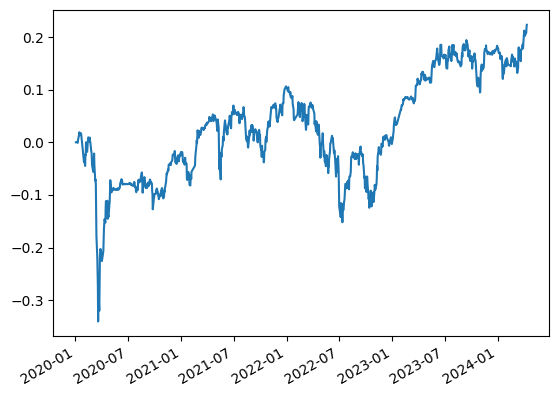

In [9]:
results.returns.cumsum().plot()

### F. Performance Evaluation Using Pyfolio

Start date,2020-01-02
End date,2024-04-10
Total months,49
,Backtest
Annual return,4.042%
Cumulative returns,17.694%
Annual volatility,17.113%
Sharpe ratio,0.32
Calmar ratio,0.13
Stability,0.44
Max drawdown,-30.921%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.92,2020-01-14,2020-03-19,2021-04-07,295
1,23.62,2021-12-29,2022-07-12,2023-04-12,307
2,11.87,2021-04-20,2021-05-17,2021-06-29,49
3,10.50,2021-06-30,2021-10-13,2021-11-22,101
4,9.59,2023-09-14,2023-10-31,2024-04-01,131


Stress Events,mean,min,max
New Normal,0.02%,-6.75%,5.83%


Top 10 long positions of all time,max
sid,
1802,31.79%
2912,29.18%
3673,27.40%
2354,24.54%
4904,23.05%
2801,22.35%
2492,21.38%
2324,20.79%
5871,19.14%


Top 10 short positions of all time,max
sid,
2227,-12.88%


Top 10 positions of all time,max
sid,
1802,31.79%
2912,29.18%
3673,27.40%
2354,24.54%
4904,23.05%
2801,22.35%
2492,21.38%
2324,20.79%
5871,19.14%


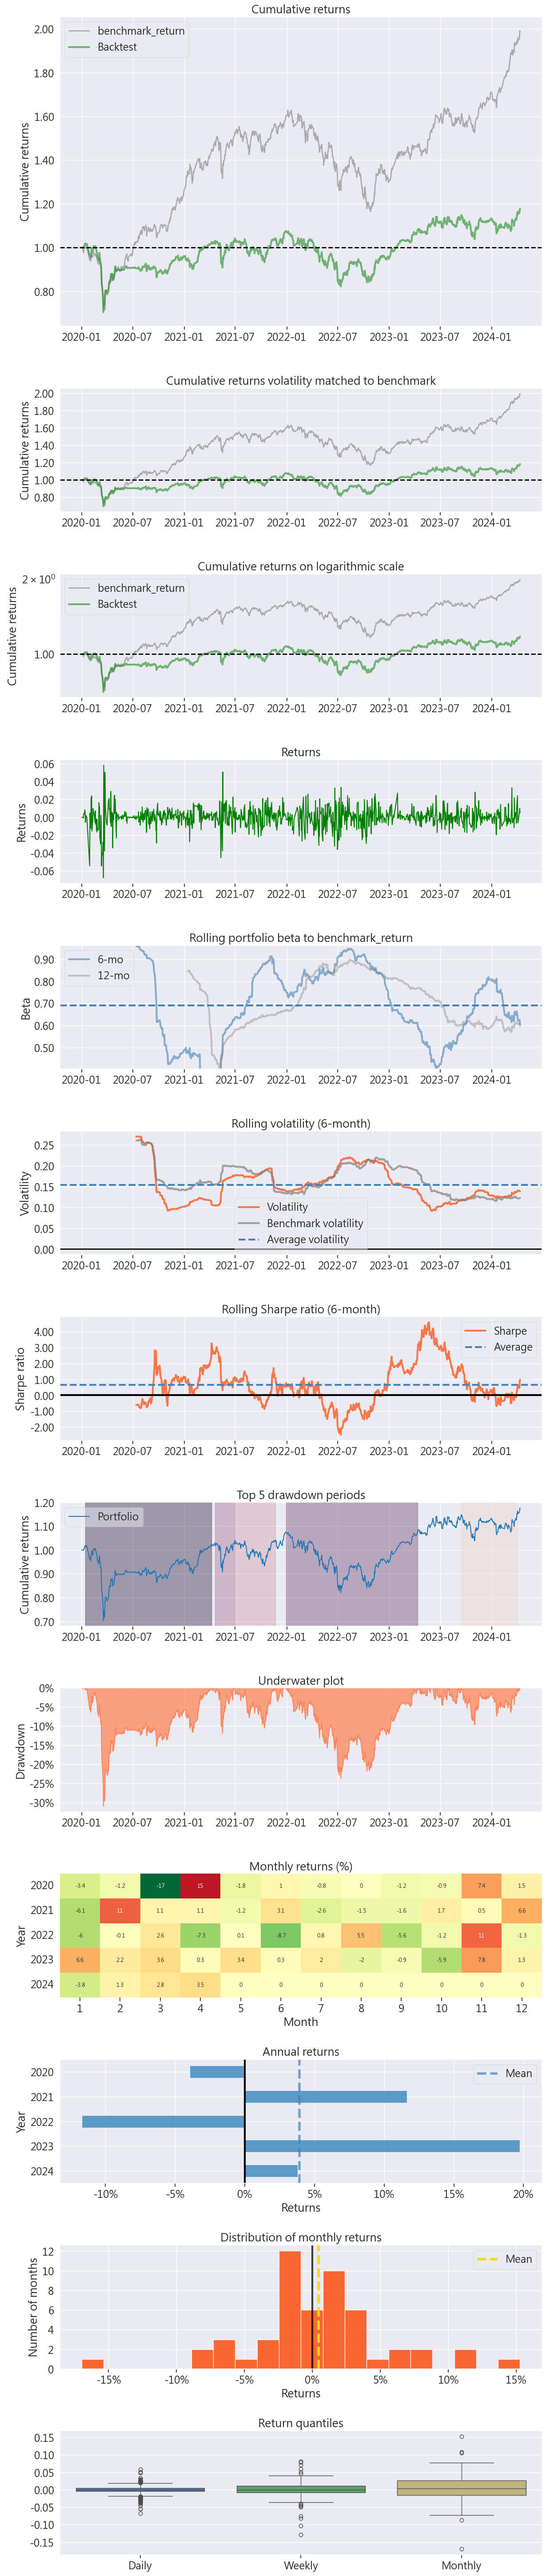

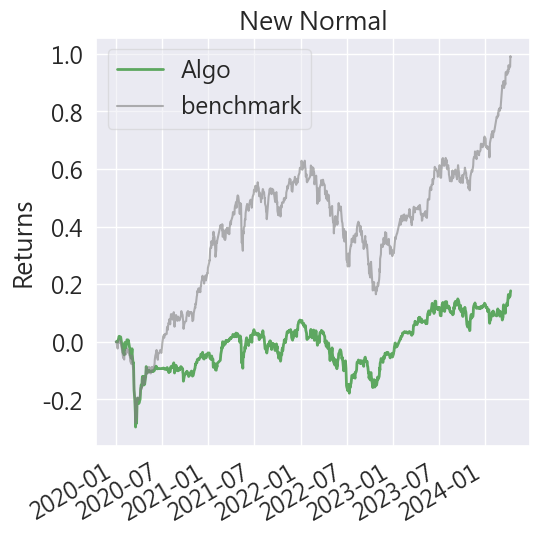

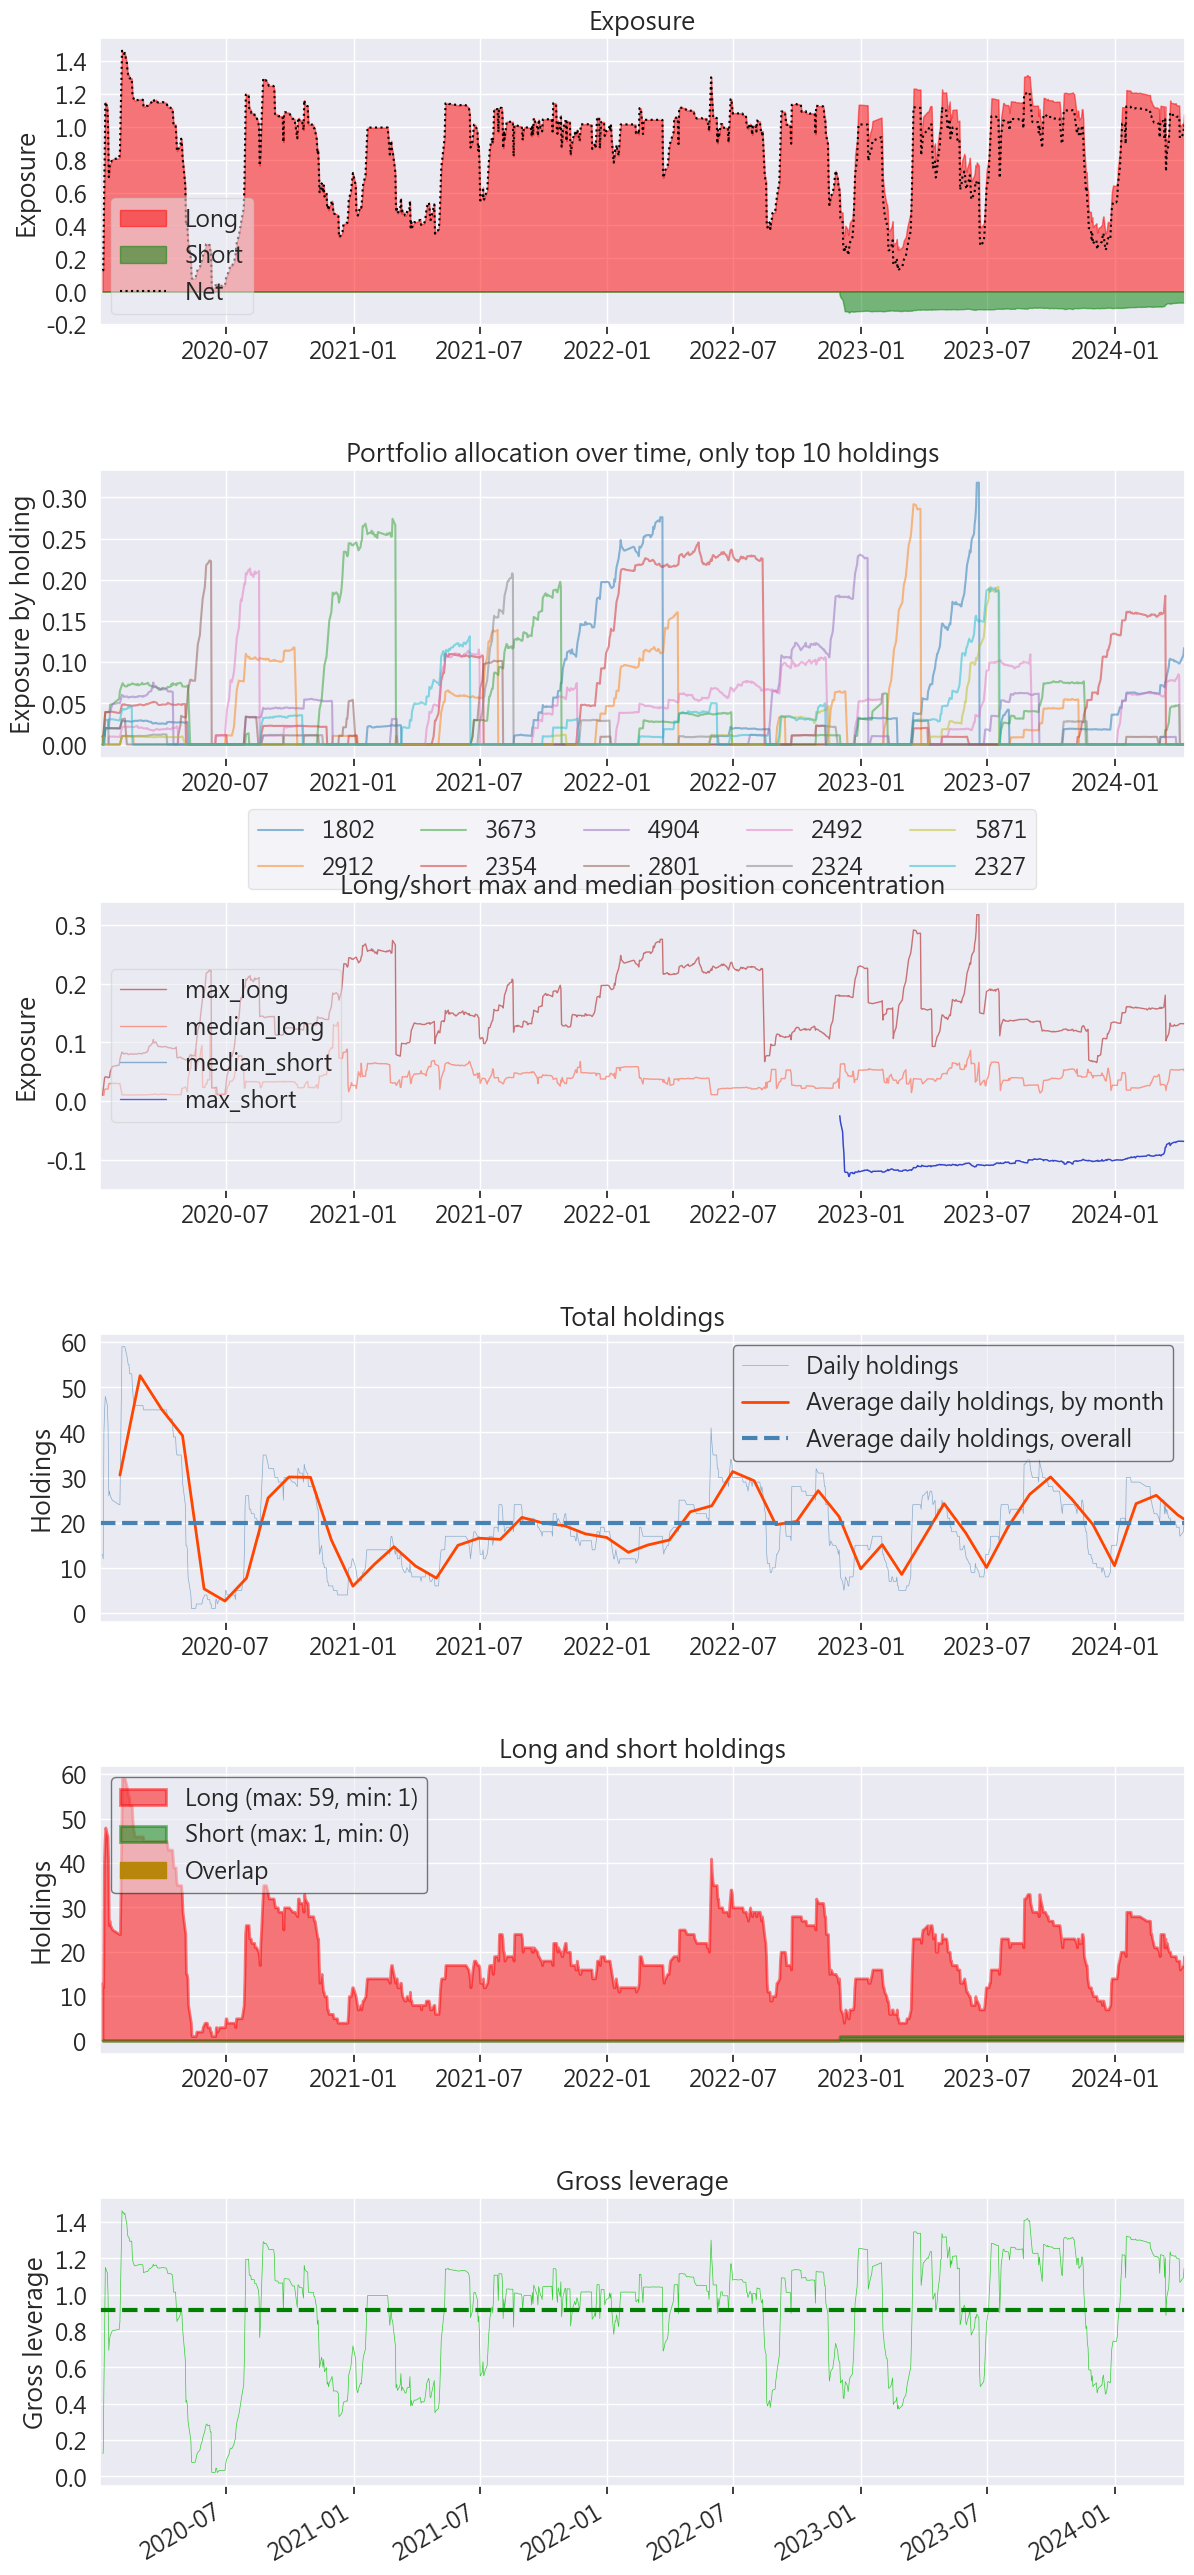

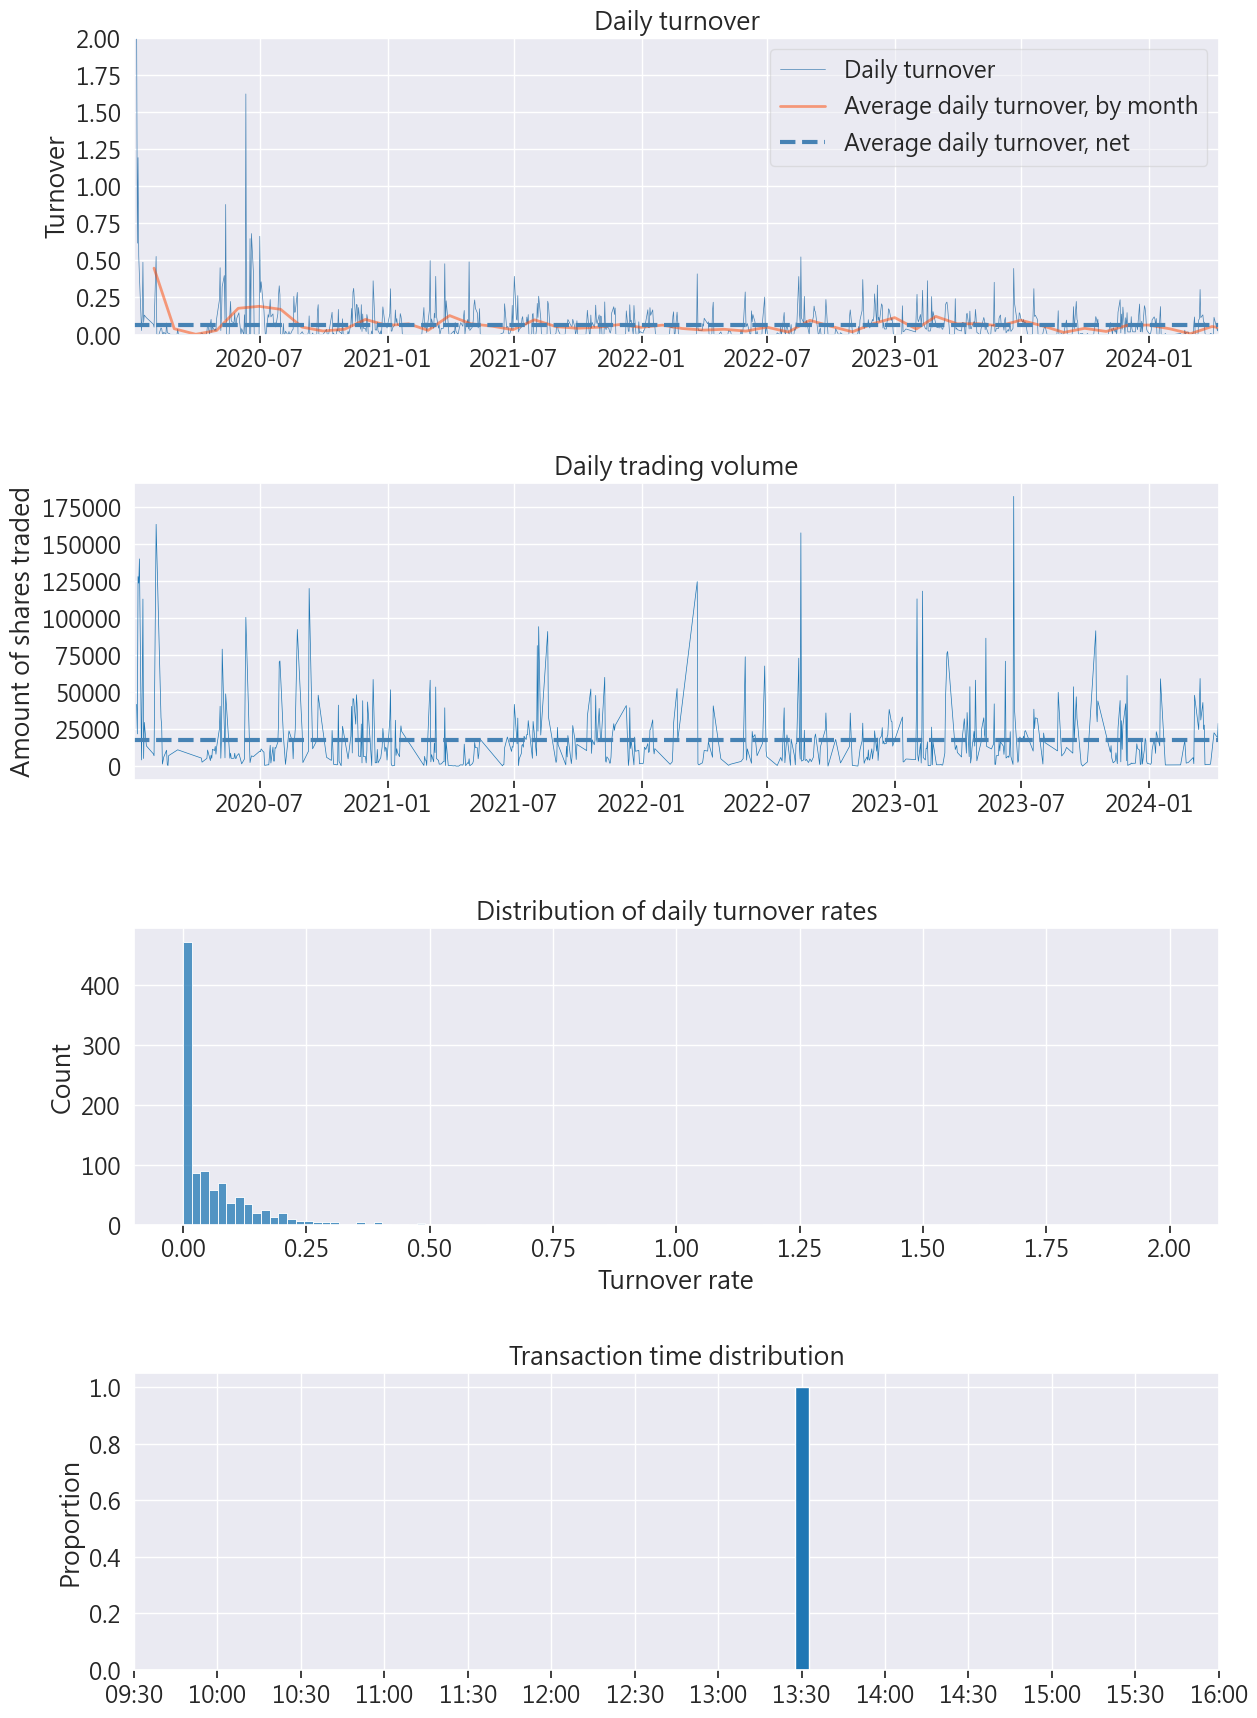

In [12]:
import pyfolio as pf

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

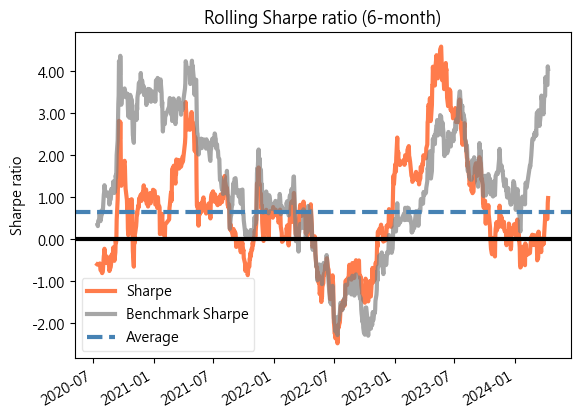

In [14]:
from pyfolio.plotting import plot_rolling_sharpe
plot_rolling_sharpe(returns, factor_returns = benchmark_rets)